# Setup

## Installs

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import gpxpy
import folium

from route import Route, RouteGroup

In [2]:
plt.ioff()  # Turn off interactive mode

# Read the GPX file and instantiate the Route object

In [3]:
GPX_FILE_PATH = '../gpx/'

# Read the GPX file
gpx_file_name = 'wtr-praiasselvagens-22-2024.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
route = Route(full_gpx_file_path)


# Usage

In [4]:
# Test that basic attributes are loaded
print("Basic attributes test:")
print(f"Total distance: {route.total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(route.elevation_gain):,} m")
print(f"Total elevation loss: {round(route.elevation_loss):,} m")
print(f"Average elevation gain per km: {round(route.avg_elevation_gain_per_km):,} m")
print(f"Route % of hard slopes (above {100*route.HARD_SLOPE_THRESHOLD:.0f}%): {100*route.hard_slope_percentage:.1f}%")

Basic attributes test:
Total distance: 20.9 km
Total elevation gain: 939 m
Total elevation loss: 939 m
Average elevation gain per km: 45 m
Route % of hard slopes (above 20%): 22.3%


In [5]:
# Plot the map
route_map = route.plot_map()
route_map

In [6]:
# Plot the elevation profile
elevation_profile = route.plot_elevation_profile()
elevation_profile


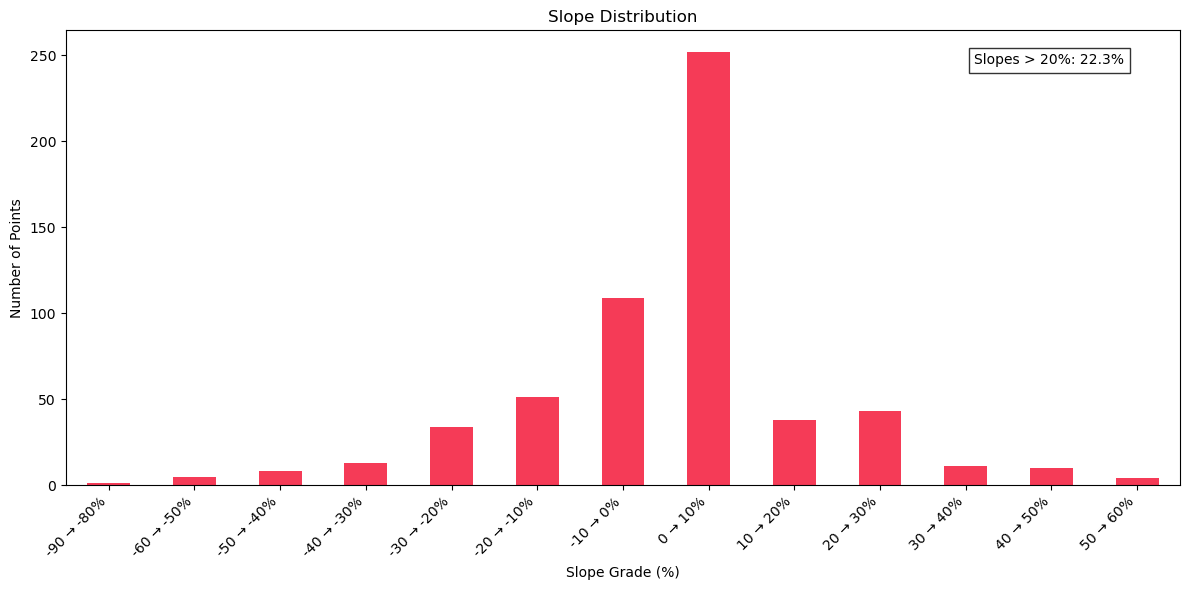

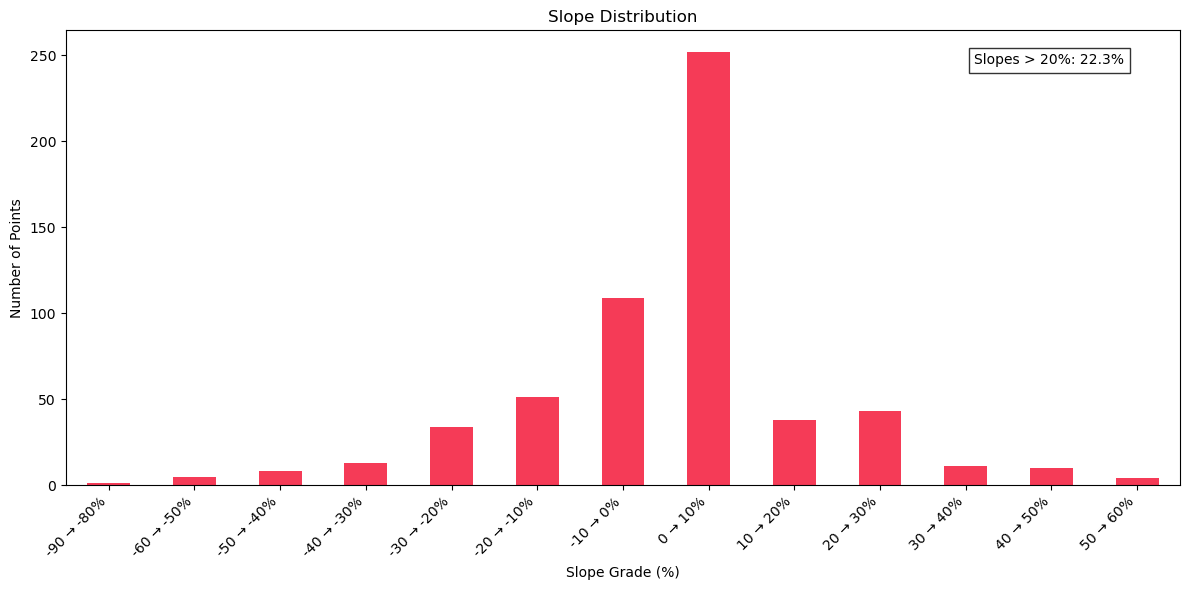

In [7]:
# Plot the slope histogram
slope_histogram = route.plot_slope_histogram()
slope_histogram

In [8]:
# Display the route's DataFrame
route.df

,latitude,longitude,elevation,elevation_diff,distance_between_points_3d,distance_between_points_2d,cum_distance_3d_km,cum_distance_2d_km,cum_elevation,slope_gradient,slope_bin,hard_slope
0,-23.04979,-43.53635,7.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0 → 10%,False
1,-23.05009,-43.53614,7.0,0.0,39.724002,39.724002,0.039724,0.039724,0.0,0.000000,0 → 10%,False
2,-23.05050,-43.53586,6.0,-1.0,53.913807,53.904532,0.093638,0.093629,-1.0,-0.018551,-10 → 0%,False
3,-23.05027,-43.53548,6.0,0.0,46.589927,46.589927,0.140228,0.140218,-1.0,0.000000,0 → 10%,False
4,-23.05004,-43.53510,6.0,0.0,46.589983,46.589983,0.186818,0.186808,-1.0,0.000000,0 → 10%,False
...,...,...,...,...,...,...,...,...,...,...,...,...
574,-23.04921,-43.53795,7.0,0.0,34.700752,34.700752,20.695238,20.454287,0.0,0.000000,0 → 10%,False
575,-23.04928,-43.53740,8.0,1.0,56.883141,56.874350,20.752121,20.511162,1.0,0.017583,0 → 10%,False
576,-23.04936,-43.53713,8.0,0.0,29.055274,29.055274,20.781176,20.540217,1.0,0.000000,0 → 10%,False
577,-23.04953,-43.53688,8.0,0.0,31.841911,31.841911,20.813018,20.572059,1.0,0.000000,0 → 10%,False


# Compare routes

In [9]:
# Create a route group
group = RouteGroup()

# Add routes with custom labels
group.add_route(
    route=Route(os.path.join(GPX_FILE_PATH, 'lamision-brasil-35-2024.gpx')),
    label='lamision-brasil-35-2024'
)
group.add_route(
    route=Route(os.path.join(GPX_FILE_PATH, 'wtr-praiasselvagens-22-2024.gpx')),
    label='wtr-praiasselvagens-22-2024'
)

# Compare stats
compare_stats_df = group.compare_stats()
display(compare_stats_df)

# Plot elevation comparison
elevation_comparison = group.plot_elevation_comparison()
elevation_comparison

,Route,Distance (km),Elevation Gain (m),Elevation Loss (m),Avg Gain per km (m),Hard Slopes (%)
0,lamision-brasil-35-2024,37.7,2772,2775,73,28.5
1,wtr-praiasselvagens-22-2024,20.9,939,939,45,22.3
